File extend_the_curve.py must be uploaded to session storage for importing later.

> N.B.: If a reset has not been done, the file may still be in session storage.

It may be necessary to download the file to your local drive and/or  upload (again)

>  extend_the_curve.py 

by manually selecting folder icon

> Files > "Upload to session storage" 

The file may be downloaded to your local drive from

    https://github.com/drbique/shared-aflcmc/blob/master/python/extend_the_curve.py

 or uncomment the following code section, run it, and then from the left Files menu, refresh, select the file and select Download

In [1]:
#!test ! -f extend_the_curve.py && curl -H 'Accept: application/vnd.github.v3.raw' --remote-name --location https://github.com/drbique/shared-aflcmc/python/extend_the_curve.py

 Purpose: Create CSV files and plots by states in U.S. with historical and forecast for both cases and deaths of COVID-19. In particular, this code demonstrates the use of extend_the_curve()

(C) COPYRIGHT NOTICE

All or portions of the documentation and software included in this software
distribution from AFLCMC/HNII are copyrighted by Stephen Bique, who has assigned
All Rights for those portions to AFLCMC/HNII.  Outside the USA, AFLCMC/HNII has
copyright on some or all of the software developed for AFLCMC/HNII. Any files may
contain specific copyright notices and those notices must be retained in any derived
work.

AFLCMC/HNII LICENSE

AFLCMC/HNII may grant permission for redistribution and use in source and binary
forms, with or without modification, of this software and documentation
created for AFLCMC/HNII provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright
   notice, this list of conditions and the following disclaimer.
2. Redistributions in binary form must reproduce the above copyright
   notice, this list of conditions and the following disclaimer in the
   documentation and/or other materials provided with the distribution.
3. All advertising materials mentioning features or use of this software
   must display the following acknowledgements:

   This product includes software developed for AFLCMC/HNII.

4. Neither the name of AFLCMC/HNII nor the names of its contributors
   may be used to endorse or promote products derived from this software
   without specific prior written permission.

THE SOFTWARE PROVIDED BY AFLCMC/HNII IS PROVIDED BY AFLCMC/HNII AND CONTRIBUTORS
``AS IS'' AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED
TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A
PARTICULAR PURPOSE ARE DISCLAIMED.  IN NO EVENT SHALL AFLCMC/HNII OR
CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL,
EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO,
PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR
PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF
LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING
NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

The views and conclusions contained in the software and documentation
are those of the authors and should not be interpreted as representing
official policies, either expressed or implied, of AFLCMC/HNII.



In [2]:
import multiprocessing as mp
agents = mp.cpu_count()


Define desired folder location for output files

In [3]:
folder = ''  # Default folder is current folder

Append the directory to your python path using sys

Fetch data

In [4]:
import pandas as pd
url_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'

df_cases = pd.read_csv(url_cases, error_bad_lines=True)
df_deaths = pd.read_csv(url_deaths, error_bad_lines=True)


Save start time for performance optimizations

In [5]:
import time
start_time = time.time()

Some abbreviations and names for 'Other' states:
'AS' American Samoa
'FM' Federated States of Micronesia
'GU' Guam
'MH' U.S.Minor Outlying Islands
'MP' 'Marshall Islands
'UM' Northern Mariana Island
'PW' Palau
'VI' U.S.Virgin Islands'

States for which we collect data:

In [6]:
states = ['Alabama','Alaska','Arkansas','Arizona', 'California','Colorado','Connecticut','Delaware','District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

Get length of rows:

In [7]:
index_len_c = df_cases.shape[0]
index_len_d = df_deaths.shape[0]


Form Boolean arrays to select rows of dataframe:

In [8]:
rows_cases = []
rows_deaths = []
for s in range(len(states)):
  rows_cases.append(df_cases['Province_State'] == states[s])
  rows_deaths.append(df_deaths['Province_State'] == states[s])

Add 'Other' states:

In [9]:
rows_cases.append(pd.Series([not(i in states) for i in df_cases['Province_State']]))
rows_deaths.append(pd.Series([not(i in states) for i in df_deaths['Province_State']]))
states.append('Other')

Insert total for all states:

In [10]:
rows_cases.insert(0, pd.Series([True] * index_len_c))
rows_deaths.insert(0, pd.Series([True] * index_len_d))
states.insert(0, 'U.S.')

num_states = len(states)

from datetime import datetime

dates_c = []
cases_dates = list(df_cases.columns)[11:]
for i in cases_dates:
  dates_c.append(datetime.strptime(i, '%m/%d/%y').strftime('%m/%d/%Y'))

dates_d = []
deaths_dates = list(df_deaths.columns)[12:]
for i in deaths_dates:
  dates_d.append(datetime.strptime(i, '%m/%d/%y').strftime('%m/%d/%Y'))


Compute partitions and ranges for the parallel agents to divide and conquer

In [11]:
if agents > num_states:
    agents = num_states # Can't distribute rows to more than rows agents

Generate partitions to divide sequence of num_items among num_workers processes:

In [12]:
def Partition(num_items, num_workers):
  partition = []  # list of pairs containing starting offsets and size [[offset0,size0],[offset1,size1],...]
  ranges = []  # list of pairs containing ranges [[offset0, last_plus_one0],[offset1, last_plus_one1],...]

  row_chunksize = num_items // num_workers
  row_chunksize1 = row_chunksize + 1
  size = num_items - num_workers * row_chunksize
  last_offset = 0
  if size != 0:
    for s in range(size):
      partition.append([last_offset, row_chunksize1])
      next_offset = last_offset + row_chunksize1
      ranges.append([last_offset, next_offset])
      last_offset = next_offset

  for s in range(num_workers - size):
    partition.append([last_offset, row_chunksize])
    next_offset = last_offset + row_chunksize
    ranges.append([last_offset, next_offset])
    last_offset = next_offset

  return partition, ranges

row_partition, row_ranges = Partition(num_states,agents)


Compute the sums per state for the number of cases and deaths

In [13]:
def update_sums_c(pair):
  result = []
  for s in range(pair[1]):
    li = []
    for i in cases_dates:
      row = pair[0]+s
      li.append(df_cases[rows_cases[row]][i].sum())
    result.append(li)
  return result

def update_sums_d(pair):
  result = []
  for s in range(pair[1]):
    li = []
    for i in deaths_dates:
      row = pair[0]+s
      li.append(df_deaths[rows_deaths[row]][i].sum())
    result.append(li)
  return result

import numpy as np

with mp.Pool(agents) as p:
  cases_states = p.map(update_sums_c,row_partition)
cases_states = np.row_stack(cases_states)

with mp.Pool(agents) as p:
  deaths_states = p.map(update_sums_d,row_partition)
deaths_states = np.row_stack(deaths_states)

Create pandas DataFrames with states as rows and dates as columns

In [14]:
dfc = pd.DataFrame(cases_states, columns=dates_c, index=states)
dfd = pd.DataFrame(deaths_states, columns=dates_d, index=states)

Get length of columns

In [15]:
col_len_c = dfc.shape[1]
col_len_d = dfd.shape[1]

Sort the dataframe by the worst as of latest data

In [16]:
df_c = dfc.sort_values(dfc.columns[-1], ascending = False)
df_d = dfd.sort_values(dfd.columns[-1], ascending = False)

Save last date for observations

In [17]:
last_date_c = dates_c[-1].replace('/', '-')
last_date_d = dates_d[-1].replace('/', '-')

Forecast

Specify number of days for which to forecast; reasonable to expect that forecast (number of days ahead) cannot be larger than the number of days upon which forecast is based

In [18]:
from datetime import datetime
from datetime import timedelta

import numpy as np

days_ahead_c = 14
start_c = dates_c[-1]
start_date_c = datetime.strptime(start_c, '%m/%d/%Y')
for i in range(days_ahead_c):
    dates_c.append((start_date_c + timedelta(days=i + 1)).strftime('%m/%d/%Y'))
future_forecast_c = np.array([float(x) for x in range(col_len_c + days_ahead_c)])

days_ahead_d = 14
start_d = dates_d[-1]
start_date_d = datetime.strptime(start_d, '%m/%d/%Y')
for i in range(days_ahead_d):
    dates_d.append((start_date_d + timedelta(days=i + 1)).strftime('%m/%d/%Y'))
future_forecast_d = np.array([float(x) for x in range(col_len_d + days_ahead_d)])


In [19]:

def make_forecast_c(blocks):
    import numpy as np
    from extend_the_curve import extend_the_curve
    return np.row_stack(np.asarray([extend_the_curve(row,days_ahead_c,returns="step") for row in blocks]))

def make_forecast_d(blocks):
    import numpy as np
    from extend_the_curve import extend_the_curve
    return np.row_stack(np.asarray([extend_the_curve(row,days_ahead_d,returns="step") for row in blocks]))

blocks_c = [df_c.iloc[ pair[0]:pair[1], :].to_numpy() for pair in row_ranges]
with mp.Pool(agents) as p:
  cases_forecast = p.map(make_forecast_c,blocks_c)
cases_forecast = np.row_stack(cases_forecast)
dfc = pd.DataFrame(np.concatenate((df_c.values,cases_forecast),axis=1), columns=dates_c, index=df_c.axes[0].to_list())

# model forecasting for number of deaths
blocks_d = [df_d.iloc[ pair[0]:pair[1], :].to_numpy() for pair in row_ranges]
with mp.Pool(agents) as p:
  deaths_forecast =  p.map(make_forecast_d,blocks_d)
deaths_forecast = np.row_stack(deaths_forecast)
dfd = pd.DataFrame(np.concatenate((df_d.values,deaths_forecast),axis=1), columns=dates_d, index=df_d.axes[0].to_list())


# Print only computation time


In [20]:
print("time elapsed prior to plotting: {:.2f} min".format((time.time() - start_time)/60))

time elapsed prior to plotting: 1.10 min


Plot results and save CSV files

time elapsed including plotting: 193.20 min


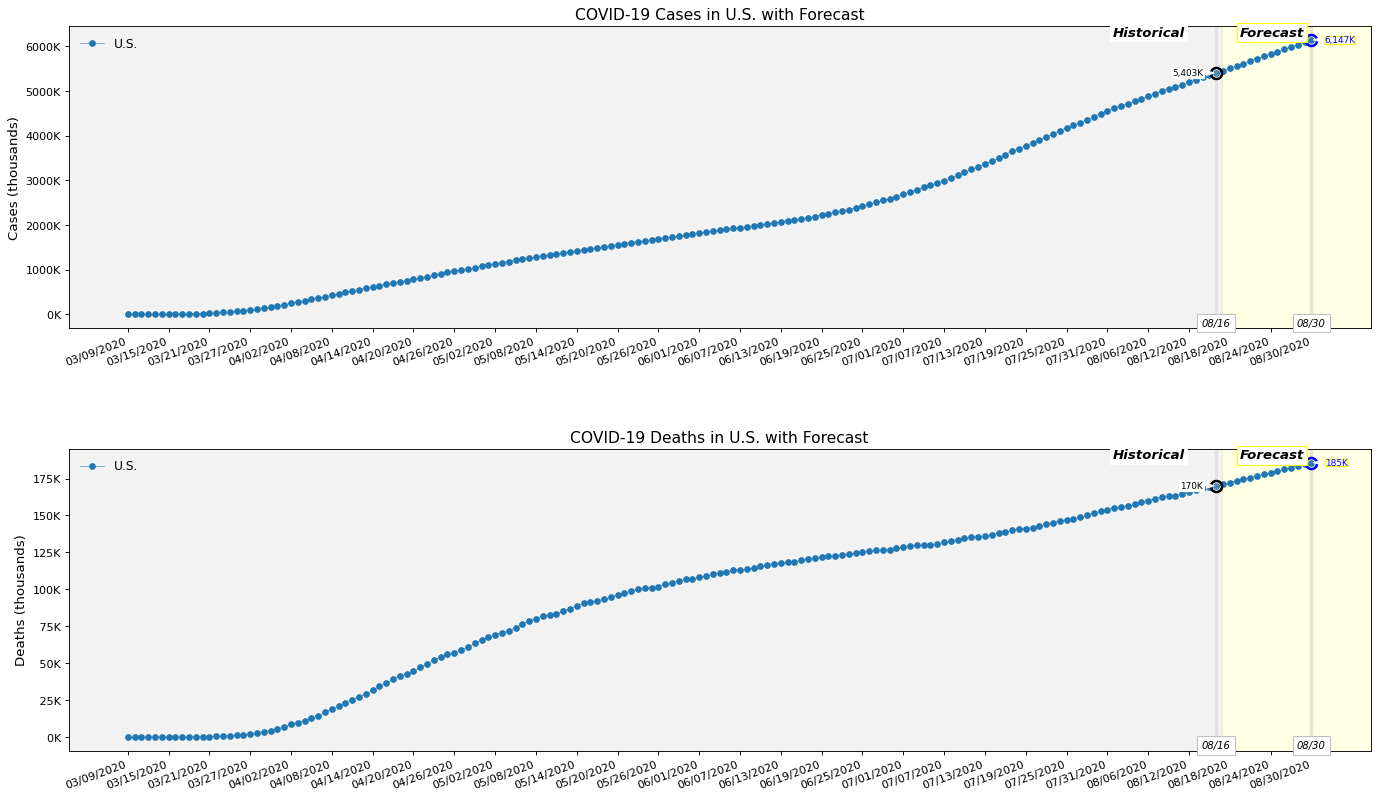

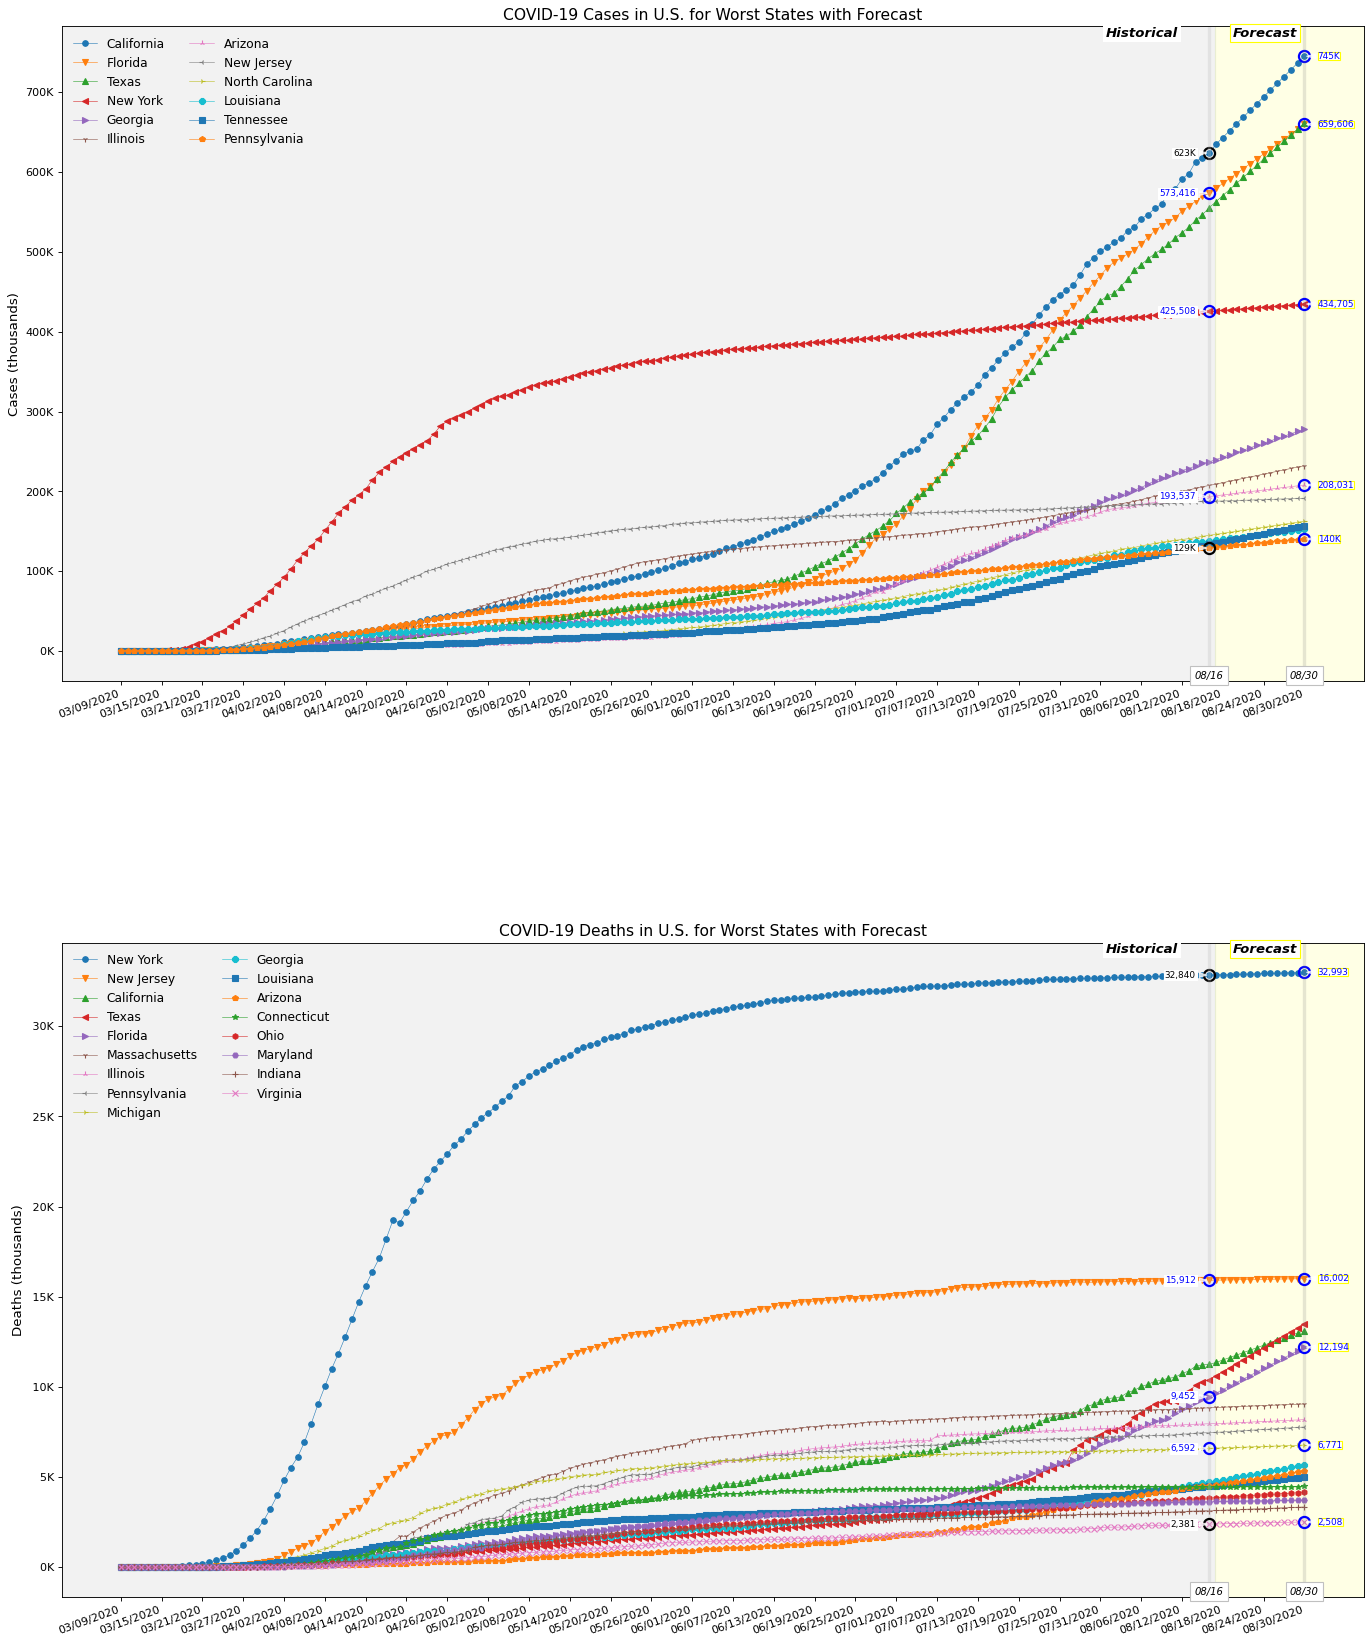

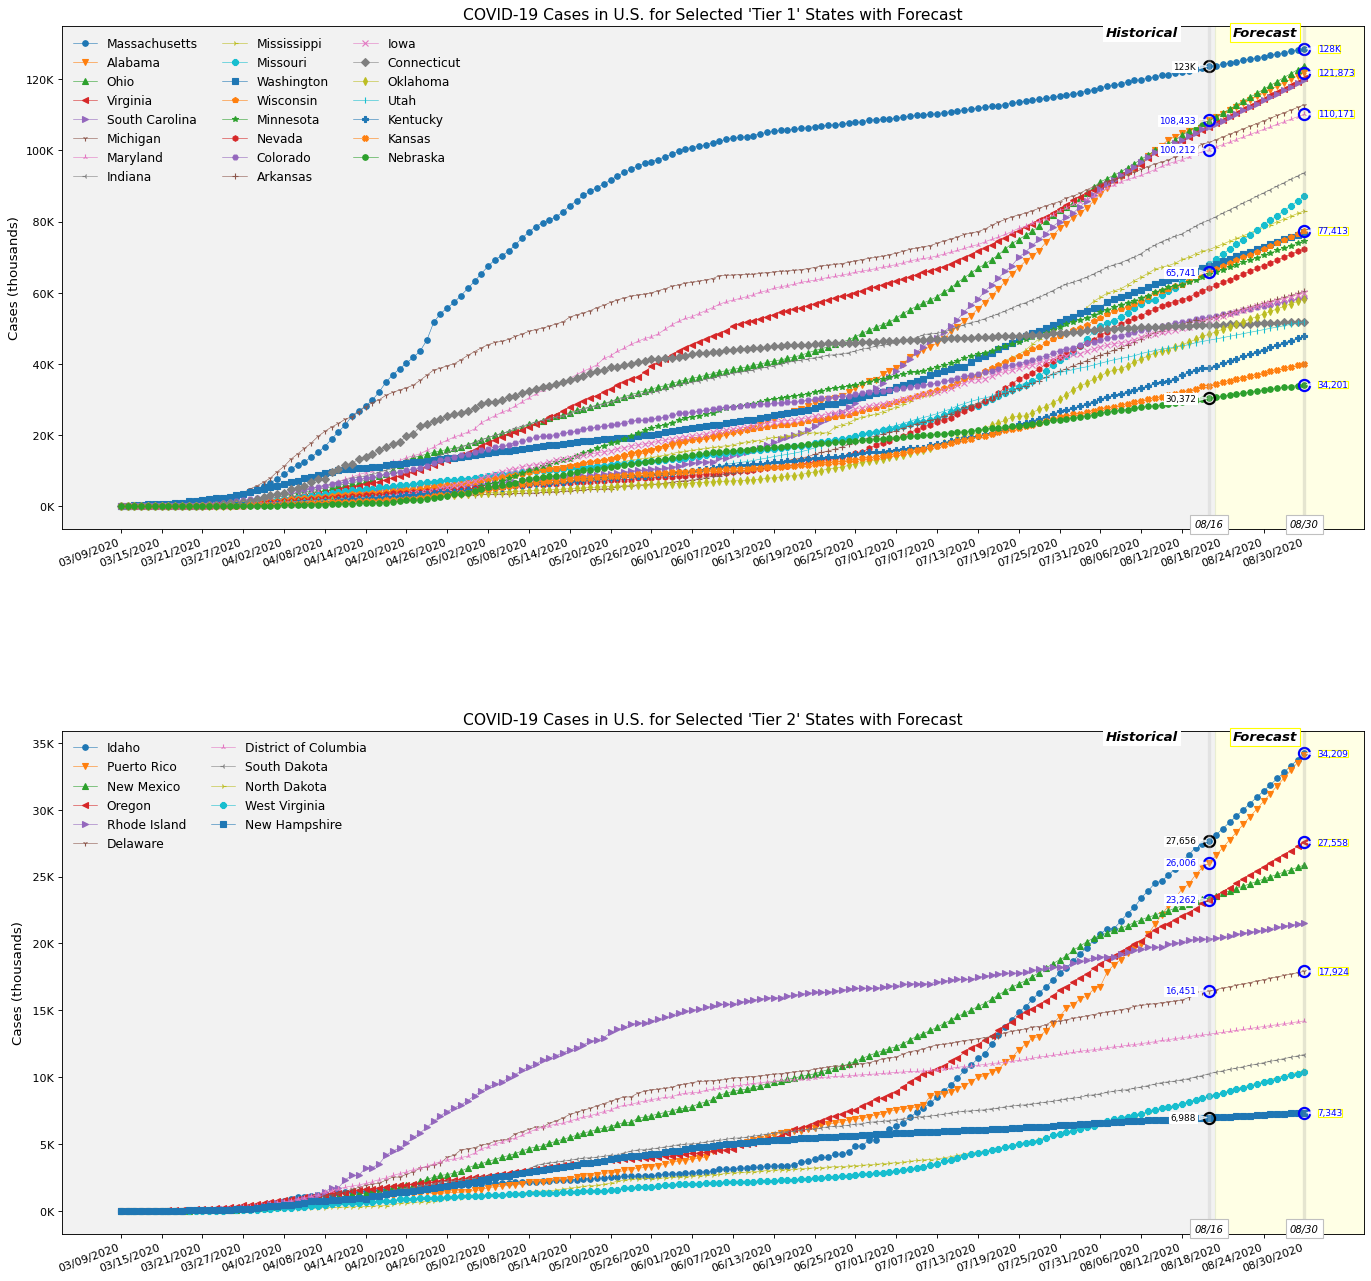

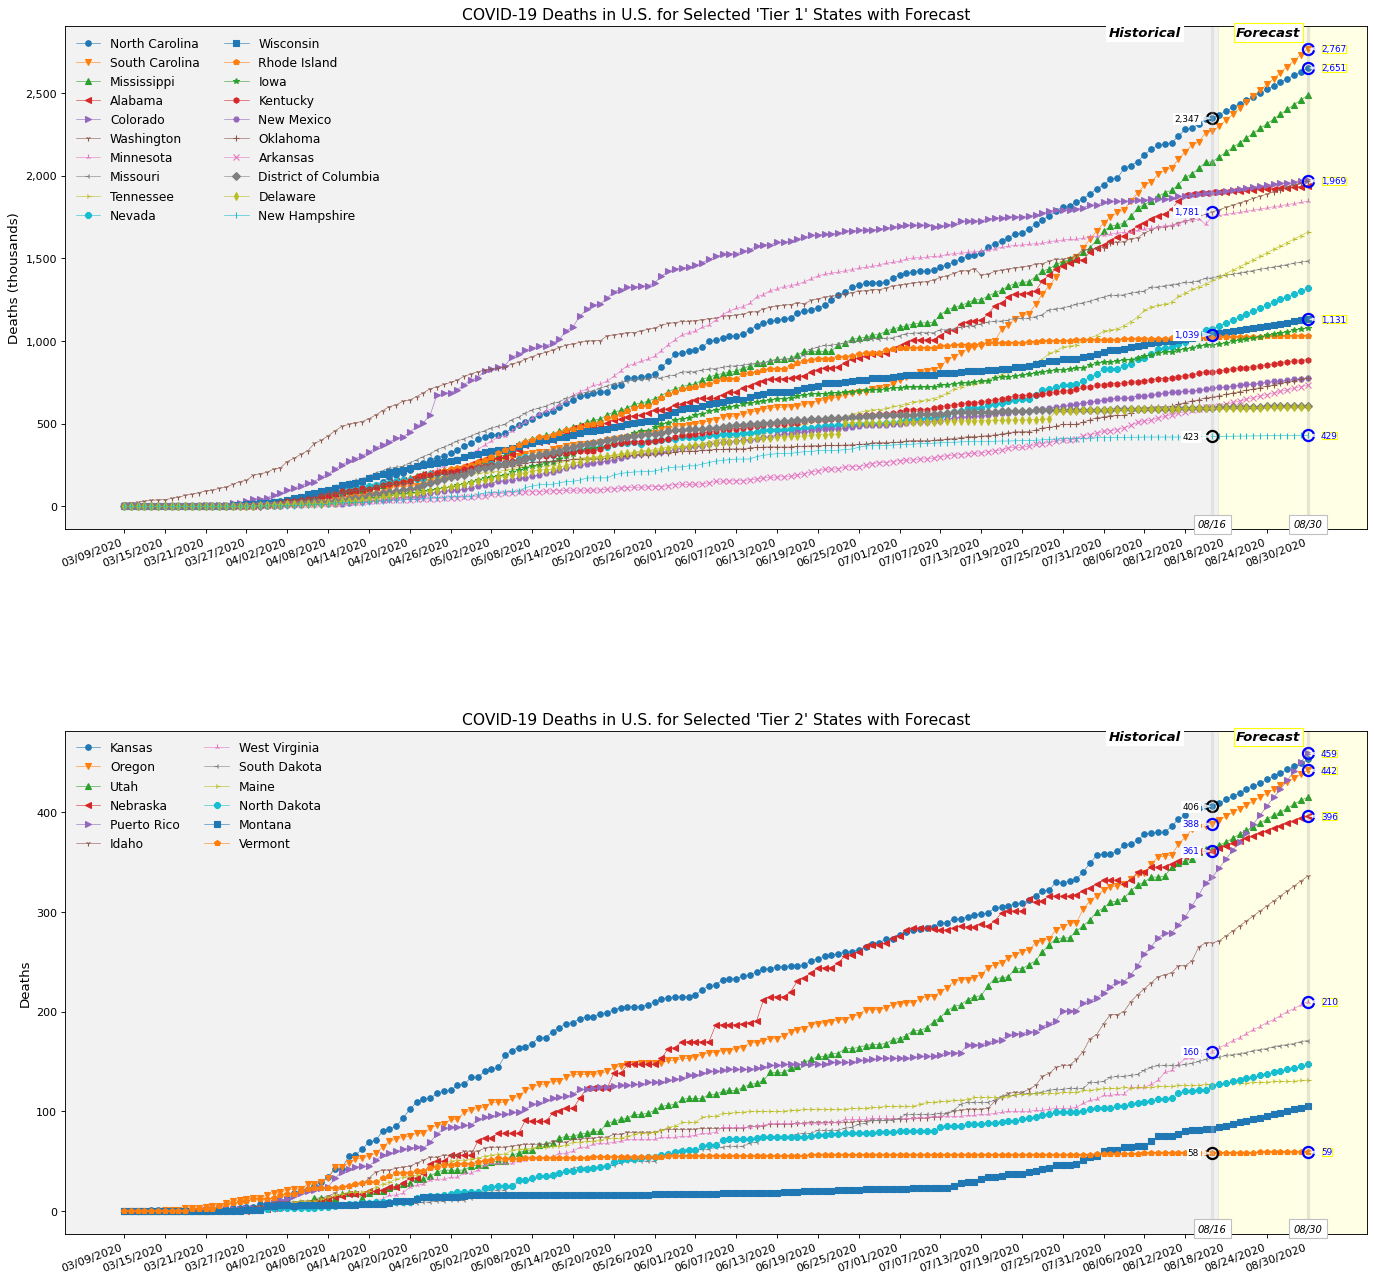

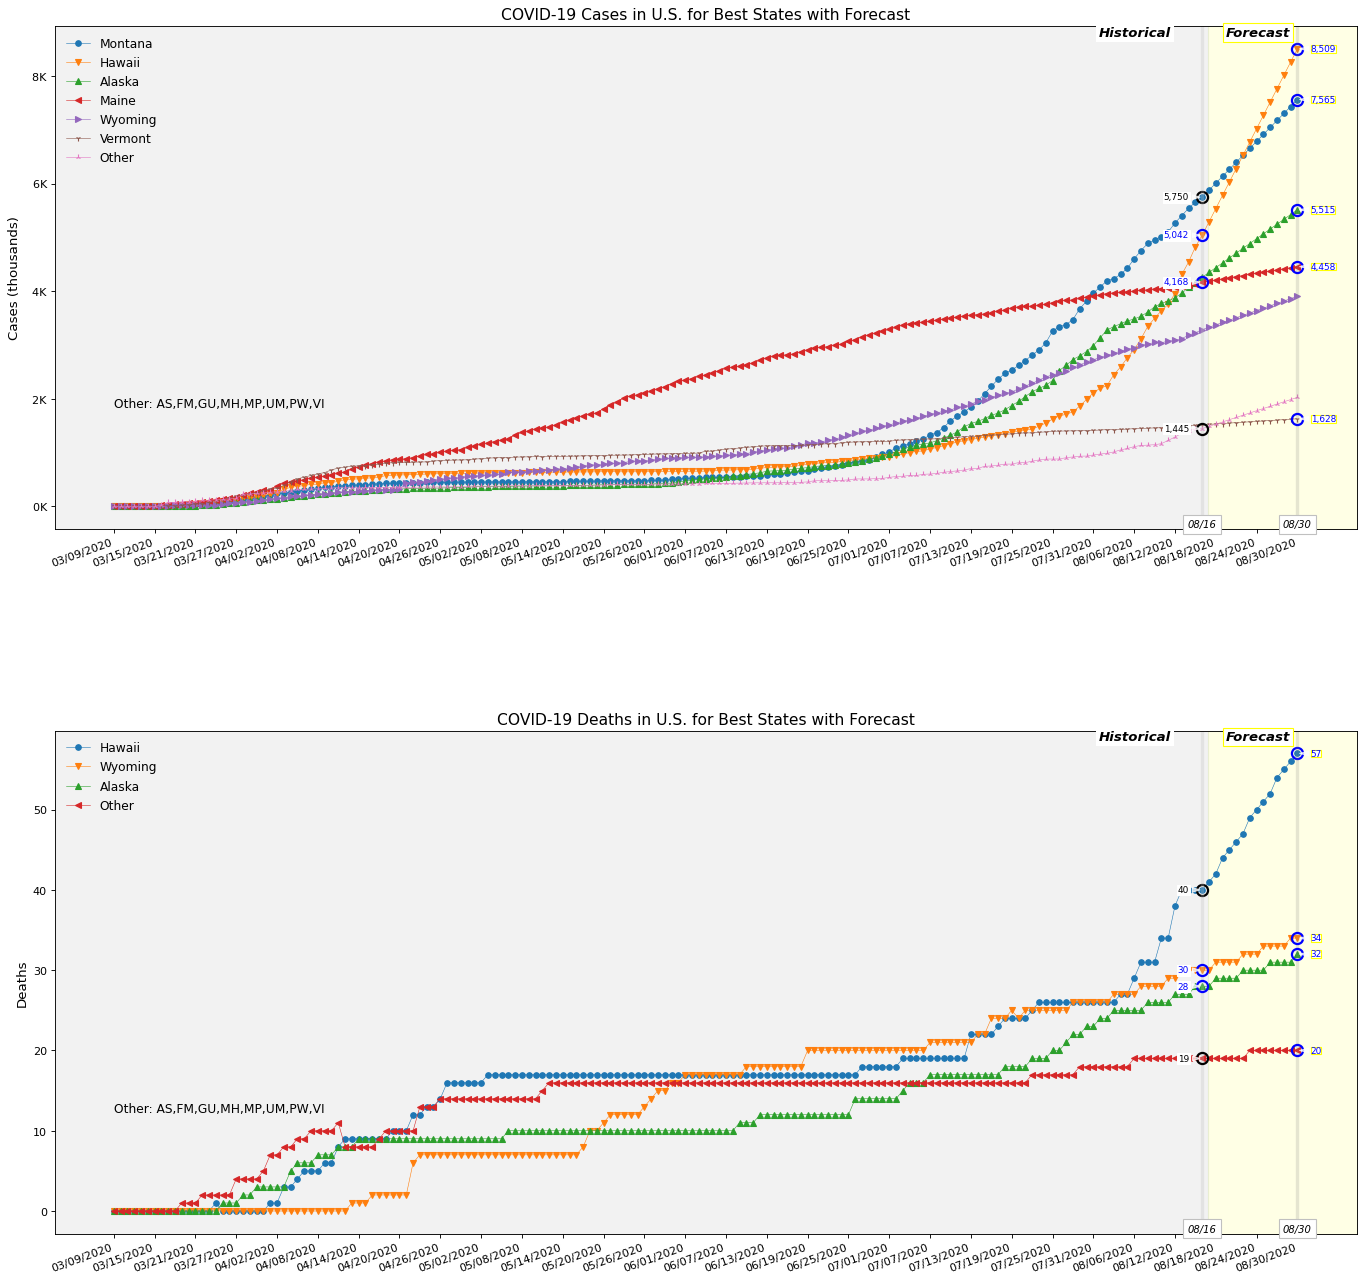

In [28]:
def make_plot( df, ax, markers, freq, xlen, days, title, ylabel ):

    #  Add markers
    for i, line in enumerate(ax.get_lines()):
        line.set_marker(markers[i])

    # Set frequency for labels on x-axis
    frequency = freq

    # Calculate the locations of the corners of the figure
    padding = 1.5  # intervals on each side
    left = xlen + padding * float(2 * frequency)  # number of dates that fit in width of frame
    left = (left - float(days - 1) - padding * float(frequency)) / left
    width = 1.0 - left
    bottom, height = 0.0, 1.0
    right, top = 1.0, 1.0

    import matplotlib.patches as patches

    topline = ax.axis()[3]
    leftline = ax.axis()[1] * left


    # Historical section
    p = patches.Rectangle(
        (0, bottom),left,height,fill=True,transform=ax.transAxes,facecolor='gray',edgecolor='silver',clip_on=False,alpha=0.1
    )
    ax.add_patch(p)
    ax.text(leftline *.96,topline,'Historical',style='italic',fontsize=12, fontweight='bold',ha="right",va="top",bbox=dict(boxstyle='square,pad=0.2',ec='none', fc='white'))

    # Forecast section
    p = patches.Rectangle(
        (left,bottom),width,height,fill=True,transform=ax.transAxes,fc='yellow',ec='yellowgreen',clip_on=False,alpha=0.1
    )
    ax.add_patch(p)
    ax.text(leftline * 1.01,topline,'Forecast',style='italic',fontsize=12,fontweight='bold',ha="left",va="top",bbox=dict(boxstyle='square,pad=0.2',ec='yellow',fc='white'))

    left = xlen - float(days + 1)
    right = float(days) + left

    import pandas

    # Print extreme points and a few interesting points in between

    # Label last observation maximum (assume data is sorted)
    max_val = df.values[0][-days - 1]
    ax.plot(left,max_val,'o',markersize=10,markeredgewidth=2,markeredgecolor='black',fillstyle='none')
    if (max_val > 99999.0):
        label = K_string(max_val)
    else:
        label = C_string(max_val)
    ax.annotate(label,(left,max_val),textcoords="offset points",xytext=(-12,0),ha='right',fontsize=8,
                va='center',backgroundcolor='w',xycoords='data',
                bbox=dict(boxstyle='square,pad=0.1',fc='white', ec='white'),
                arrowprops=dict(arrowstyle="wedge,tail_width=0.5",color='white',alpha=0.75))
    # Label date line
    ax.axvline(x=left,color='silver',linewidth = 3,alpha=0.3)
    bottomline = ax.axis()[2]
    ax.text(left,bottomline,'{0:s}'.format(df.columns[-days - 1][:5]),style='italic',size=9,ha="center",va="bottom",bbox=dict(ec='silver', fc='white'))

    # Label last observation minimum (assume data is sorted)
    min_val = df.values[-1][-days - 1]
    ax.plot(left, min_val, 'o', markersize=10, markeredgewidth=2, markeredgecolor='black', fillstyle='none')
    if (min_val > 99999.0):
        label = K_string(min_val)
    else:
        label = C_string(min_val)
    ax.annotate(label,(left,min_val),textcoords="offset points",xytext=(-12,0),ha='right',fontsize=8,
                va='center',backgroundcolor='w',xycoords='data',
                bbox=dict(boxstyle='square,pad=0.1',fc='white', ec='white'),
                arrowprops=dict(arrowstyle="wedge,tail_width=0.5",color='white',alpha=0.75))


    # Label last prediction maximum value - N.B. prediction can and does change rankings
    max_index = df.iloc[:,-1].values.argmax() # row containing maximum
    max_value = df.values[max_index][-1]
    ax.plot(right, max_value, 'o', markersize=10, markeredgewidth=2, markeredgecolor='blue',fillstyle='none')
    if (max_value > 99999.0):
        label = K_string(max_value)
    else:
        label = C_string(max_value)
    ax.annotate(label,(right, max_value),textcoords="offset points",xytext=(12,0),ha='left',fontsize=8,
                va='center',color='blue',backgroundcolor='w',xycoords='data',
                bbox=dict(boxstyle='square,pad=-0.07',fc='white', ec='yellow'),
                arrowprops=dict(arrowstyle="wedge,tail_width=0.5",color='white',alpha=0.75))
    ax.axvline(x=right,color='gray',linewidth = 3,alpha=0.2)
    ax.text(right,bottomline,'{0:s}'.format(df.columns[-1][:5]),style='italic',size=9,ha="center",va="bottom",bbox=dict(ec='silver', fc='white'))

    # Label last prediction minimum value - N.B. prediction can and does change rankings
    min_index = df.iloc[:,-1].values.argmin() # row containing maximum
    min_value = df.values[min_index][-1]
    ax.plot(right, min_value, 'o', markersize=10, markeredgewidth=2, markeredgecolor='blue',fillstyle='none')
    if (min_value > 99999.0):
        label = K_string(min_value)
    else:
        label = C_string(min_value)
    ax.annotate(label,(right,min_value),textcoords="offset points",xytext=(12,0),ha='left',fontsize=8,
                va='center',color='blue',backgroundcolor='w',xycoords='data',
                bbox=dict(boxstyle='square,pad=-0.07',fc='white', ec='yellow'),
                arrowprops=dict(arrowstyle="wedge,tail_width=0.5",color='white',alpha=0.75))

    maximum = max(max_val,max_value)
    nrows = len(df.index) # number of rows

    if nrows > 1:
        # Print other interesting points, but don't mess it up!

        # Print second maximum

        # Observed 2nd max based on current ranking
        value_obs2 = df.values[1][-days - 1]
        if (max_val - value_obs2) / maximum >= 0.0333:  # Skip if too close to observed maximum value
            ax.plot(left, value_obs2, 'o', markersize=10, markeredgewidth=2, markeredgecolor='blue', fillstyle='none')
            if (value_obs2 >= 1e6):
                label = K_string(value_obs2)
            else:
                label = C_string(value_obs2)
            ax.annotate(label, (left, value_obs2), textcoords="offset points", xytext=(-12, 0), ha='right', fontsize=8,
                        va='center', color='blue', backgroundcolor='w', xycoords='data',
                        bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='white'),
                        arrowprops=dict(arrowstyle="wedge,tail_width=0.5", color='white', alpha=0.75))

        # Predicted 2nd max based on current ranking, unless 2nd max is the predicted maximum
        # We avoid sorting to find second max and look only what has happened to observed second value,
        # and if it becomes the max, then we look what happened to previous max
        if max_index == 1:
            index2 = 0
        else:
            index2 = 1
        value2 = df.values[index2][-1]
        if (max_value - value2) / maximum >= 0.0333:  # Skip if too close to observed maximum value
            ax.plot(right, value2, 'o', markersize=10, markeredgewidth=2, markeredgecolor='blue', fillstyle='none')
            if (value2 >= 1e6):
                label = K_string(value2)
            else:
                label = C_string(value2)
            ax.annotate(label, (right, value2), textcoords="offset points", xytext=(12, 0), ha='left', fontsize=8,
                        va='center', color='blue', backgroundcolor='w', xycoords='data',
                        bbox=dict(boxstyle='square,pad=-0.07', fc='white', ec='yellow'),
                        arrowprops=dict(arrowstyle="wedge,tail_width=0.5", color='white', alpha=0.75))

        # Label last 'median' values - N.B. prediction can and does change rankings (here, median refers to current ranking only)
        # In fact, we are plotting an 'interesting point' and if this state has changed ranking, it is only more interesting.

        # Observed median based on current ranking
        median_index = nrows // 2  # row number that is the median
        median_value_obs = df.values[median_index][-days - 1]
        if ((median_value_obs - min_val) / maximum >= 0.0333) and (
                abs(median_value_obs - value_obs2) / maximum >= 0.0333):  # Skip if too close to mediam value
            ax.plot(left, median_value_obs, 'o', markersize=10, markeredgewidth=2, markeredgecolor='blue',
                    fillstyle='none')
            if (median_value_obs >= 1e6):
                label = K_string(median_value_obs)
            else:
                label = C_string(median_value_obs)
            ax.annotate(label, (left, median_value_obs), textcoords="offset points", xytext=(-12, 0), ha='right',
                        fontsize=8,
                        va='center', color='blue', backgroundcolor='w', xycoords='data',
                        bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='white'),
                        arrowprops=dict(arrowstyle="wedge,tail_width=0.5", color='white', alpha=0.75))

        # Predicted median
        median_value_pred = df.values[median_index][-1]
        if (median_value_pred - min_value) / maximum >= 0.0333:  # Skip if too close to minimum value
            ax.plot(right, median_value_pred, 'o', markersize=10, markeredgewidth=2, markeredgecolor='blue',
                    fillstyle='none')
            if (median_value_pred >= 1e6):
                label = K_string(median_value_pred)
            else:
                label = C_string(median_value_pred)
            ax.annotate(label, (right, median_value_pred), textcoords="offset points", xytext=(12, 0), ha='left',
                        fontsize=8,
                        va='center', color='blue', backgroundcolor='w', xycoords='data',
                        bbox=dict(boxstyle='square,pad=-0.07', fc='white', ec='yellow'),
                        arrowprops=dict(arrowstyle="wedge,tail_width=0.5", color='white', alpha=0.75))

        # Lastly, let's look the 'median' between 2nd max and median
        # Observed
        index = (median_index + 1) // 2
        value = df.values[index][-days - 1]
        if (abs(value_obs2 - value) / maximum >= 0.0333) and (
                abs(median_value_obs - value) / maximum >= 0.0333):  # Skip if too close
            ax.plot(left, value, 'o', markersize=10, markeredgewidth=2, markeredgecolor='blue', fillstyle='none')
            if (value >= 1e6):
                label = K_string(value)
            else:
                label = C_string(value)
            ax.annotate(label, (left, value), textcoords="offset points", xytext=(-12, 0), ha='right',
                        fontsize=8,
                        va='center', color='blue', backgroundcolor='w', xycoords='data',
                        bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='white'),
                        arrowprops=dict(arrowstyle="wedge,tail_width=0.5", color='white', alpha=0.75))

        # Predicted
        value = df.values[index][-1]  # use same index
        if (abs(value2 - value) / maximum >= 0.0333) and (
                abs(median_value_pred - value) / maximum >= 0.0333):  # Skip if too close
            ax.plot(right, value, 'o', markersize=10, markeredgewidth=2, markeredgecolor='blue',
                    fillstyle='none')
            if (value >= 1e6):
                label = K_string(value)
            else:
                label = C_string(value)
            ax.annotate(label, (right, value), textcoords="offset points", xytext=(12, 0), ha='left',
                        fontsize=8,
                        va='center', color='blue', backgroundcolor='w', xycoords='data',
                        bbox=dict(boxstyle='square,pad=-0.07', fc='white', ec='yellow'),
                        arrowprops=dict(arrowstyle="wedge,tail_width=0.5", color='white', alpha=0.75))

    # Add legend upper-left with medium font in ncol columns
    if nrows > 20:
        ncol = 3
    elif nrows > 10:
        ncol = 2
    else:
        ncol = 1
    ax.legend(ax.get_lines(), df.index, prop={'size': 11}, loc='upper left', ncol=ncol,frameon=False)

    # Add legend for 'Other' if it exists in dataframe
    if (df.index == 'Other').any():
        ax.text(0,ax.axis()[3]*.2,'Other: AS,FM,GU,MH,MP,UM,PW,VI', verticalalignment='bottom',horizontalalignment='left',color='black',fontsize=11)

    # Add y-label
    ax.set_ylabel(ylabel, fontsize=12)

    # Set nice ticks on y-axis
    from matplotlib.ticker import FuncFormatter
    if (max_value >= 3000):
        ax.yaxis.set_major_formatter(FuncFormatter(thousands))
    else:
        ax.yaxis.set_major_formatter(FuncFormatter(comma))

    # Make nice labels on x-axes with rotation
    from matplotlib.ticker import FixedLocator, FixedFormatter
    ax.xaxis.set_major_locator(FixedLocator(np.arange(0, xlen, freq)))
    ax.xaxis.set_major_formatter(FixedFormatter(df.columns[::freq]))
    #ax.set_xticklabels(df.columns[::freq], fontsize=12)
    for label in ax.get_xticklabels():
        label.set_rotation(20)
        label.set_horizontalalignment('right')

    # Add title
    ax.set_title(title, fontsize=14)


def subplots(t):
    (df1,df2, fig, axes, markers1,markers2, freq1,freq2, xlen1,xlen2, days1,days2, title1,title2, ylabel1,ylabel2, file) = t

    #########################
    # First subplot

    import pandas
    ax  = df1.T.plot(ax=axes[0], lw=0.5, marker='o', markersize=5)

    make_plot(df1, ax, markers1, freq1, xlen1, days1, title1, ylabel1 )

    ###########################
    # Second subplot

    ax_ = df2.T.plot(ax=axes[1], lw=0.5, marker='s', markersize=5)

    make_plot(df2, ax_, markers2, freq2, xlen2, days2, title2, ylabel2 )

    fig.subplots_adjust(hspace=0.4)

    # #########################
    # Save plot

    import matplotlib.pyplot as plt
    fig.savefig(file, dpi=300)


# create 'full' list of available markers
marks = ['o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', 'P', 'X']

markers_c = np.resize(marks, dfc.shape[0])
markers_d = np.resize(marks, dfd.shape[0])

def K_string(x):
    return '{0:,}K'.format(int(x * 1e-3))

def C_string(x):
    return '{0:,}'.format(int(x))

# Format functions for y-axis
def comma(x, pos):  # formatter function takes tick label and tick position
   return '{:0,d}'.format(int(x))

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%3dK' % (x * 1e-3)


# Ignore initial dates when numbers are low, choose somewhere in 3/2-3/17
from datetime import datetime
first_c = (datetime.strptime('03/09/2020', '%m/%d/%Y').date() - datetime.strptime(dates_c[0], '%m/%d/%Y').date()).days
first_d = (datetime.strptime('03/09/2020', '%m/%d/%Y').date() - datetime.strptime(dates_d[0], '%m/%d/%Y').date()).days

# Specify number of axes in subplots to provide a better comparison of states

import matplotlib.pyplot as plt

'''
Set sizes for each plot

Upon running the code, it is easy to see if there is a 'good' separation so that comparison is useful, and if not, 
adjust the numbers above accordingly or as desired. The idea is that all of the states are partitioned into four 
categories from worst to best as follows

                                 worst
                                 Tier 1
                                 Tier 2
                                 best

for both the number of cases and the number of deaths, and only the first three are specified as the remaining is 
then determined (since the total number is fixed).
'''
num_worst_c = 12          # number of states to include in 'Worst' for cases
num_cases_tier1 = 23      # number of states to include in 'Tier 1' for cases
num_cases_tier2 = 11      # number of states to include in 'Tier 2' for cases

num_worst_d = 17          # number of states to include in 'Worst' for deaths
num_deaths_tier1 = 20     # number of states to include in 'Tier 1' for deaths
num_deaths_tier2 = 12     # number of states to include in 'Tier 2' for deaths

# First two subplots consist of cumulative (US) for both cases and deaths
fig0, axes0 = plt.subplots(2,num=1,figsize=(21,12), dpi=80)
num_axes0 = 0
num_axes0_ = 1
df0_1 = dfc.iloc[num_axes0:num_axes0_,first_c:]
df0_2 = dfd.iloc[num_axes0:num_axes0_,first_d:]

# Next two subplots consist of worst num_worst states for both cases and deaths
fig1, axes1 = plt.subplots(2,num=2,figsize=(21,26), dpi=80)
num_axes1 = num_axes0_
num_axes1_c = num_axes1 + num_worst_c
num_axes1_d = num_axes1 + num_worst_d
df1_1 = dfc.iloc[num_axes1:num_axes1_c,first_c:]
df1_2 = dfd.iloc[num_axes1:num_axes1_d,first_d:]

# Next two subplots consists of next worst num_cases_tier1 and num_cases_tier2 states, resp., which is adjusted
# depending on the apparent rankings, for cases only

fig2, axes2 = plt.subplots(2,num=3,figsize=(21,20), dpi=80)
num_c_axes2  = num_axes1_c
num_c_axes2_ = num_c_axes2 + num_cases_tier1
num_c_axes3  = num_c_axes2_
num_c_axes3_ = num_c_axes3 + num_cases_tier2
df2_1 = dfc.iloc[num_c_axes2:num_c_axes2_,first_c:]
df2_2 = dfc.iloc[num_c_axes3:num_c_axes3_,first_c:]

# Next two subplots consist of next worst num_deaths_tier1 and num_deaths_tier2 states, resp., which is adjusted
# depending on the apparent rankings, for deaths only
fig3, axes3 = plt.subplots(2,num=4,figsize=(21,20), dpi=80)
num_d_axes2  = num_axes1_d
num_d_axes2_ = num_d_axes2 + num_deaths_tier1
num_d_axes3  = num_d_axes2_
num_d_axes3_ = num_d_axes3 + num_deaths_tier2
df3_1 = dfd.iloc[num_d_axes2:num_d_axes2_,first_d:]
df3_2 = dfd.iloc[num_d_axes3:num_d_axes3_,first_d:]

# Next two subplots consist of remaining best states for cases and deaths
fig4, axes4 = plt.subplots(2,num=5,figsize=(21,20), dpi=80)
df4_1 = dfc.iloc[num_c_axes3_:,first_c:]
df4_2 = dfd.iloc[num_d_axes3_:,first_d:]

# Set frequency for labels on x-axes
freq_c = (len(dates_c) - first_c + 31)// 32
freq_d = (len(dates_d) - first_d + 31)// 32

# Compute length of x-axis
xlen_c = float(len(dates_c) - first_c)
xlen_d = float(len(dates_d) - first_d)

tasks=((df0_1, df0_2, fig0, axes0, markers_c,markers_d,freq_c,freq_d,xlen_c,xlen_d,days_ahead_c,days_ahead_d,
        'COVID-19 Cases in U.S. with Forecast',
        'COVID-19 Deaths in U.S. with Forecast',
        'Cases (thousands)','Deaths (thousands)',
        folder+'COVID-19-US-Forecast-'+last_date_c+'.png'),
       (df1_1, df1_2, fig1, axes1, markers_c, markers_d, freq_c, freq_d, xlen_c, xlen_d, days_ahead_c, days_ahead_d,
        'COVID-19 Cases in U.S. for Worst States with Forecast',
        'COVID-19 Deaths in U.S. for Worst States with Forecast',
        'Cases (thousands)', 'Deaths (thousands)',
        folder + 'COVID-19-Worst-States-with-Forecast-' + last_date_c + '.png'),
       (df2_1,df2_2,fig2,axes2,markers_c,markers_c,freq_c,freq_c,xlen_c,xlen_c,days_ahead_c,days_ahead_c,
        "COVID-19 Cases in U.S. for Selected 'Tier 1' States with Forecast", "COVID-19 Cases in U.S. for Selected 'Tier 2' States with Forecast",
        'Cases (thousands)','Cases (thousands)',folder + 'COVID-19-Cases-for-Tier-States-' + last_date_c + '.png'),
       (df3_1,df3_2,fig3,axes3,markers_d,markers_d,freq_d,freq_d,xlen_d,xlen_d,days_ahead_d,days_ahead_d,
        "COVID-19 Deaths in U.S. for Selected 'Tier 1' States with Forecast",
        "COVID-19 Deaths in U.S. for Selected 'Tier 2' States with Forecast",
        'Deaths (thousands)','Deaths',folder+'COVID-19-Deaths-for-Tier-States-'+last_date_d+'.png'),
       (df4_1,df4_2,fig4,axes4,markers_c,markers_d,freq_c,freq_d,xlen_c,xlen_d,days_ahead_c,days_ahead_d,
        'COVID-19 Cases in U.S. for Best States with Forecast','COVID-19 Deaths in U.S. for Best States with Forecast',
        'Cases (thousands)','Deaths',folder+'COVID-19-Best-States-with-Forecast-'+last_date_c+'.png'))


# Make plots

for input in tasks:
    subplots(input)

print("time elapsed including plotting: {:.2f} min".format((time.time() - start_time)/60))

# Save data sets to CSV files

dfc.to_csv(folder + 'COVID-19-Cases-' + last_date_c + '.csv', mode ='w')
dfd.to_csv(folder + 'COVID-19-Deaths-' + last_date_d + '.csv', mode ='w')

# Show plot
plt.show()

In [22]:
!zip "`date +%m-%d-%Y`-COVID-19-forecast.zip" *.csv *.png
!rm *.csv *.png

  adding: COVID-19-Cases-08-16-2020.csv (deflated 67%)
  adding: COVID-19-Deaths-08-16-2020.csv (deflated 75%)
  adding: COVID-19-Best-States-with-Forecast-08-16-2020.png (deflated 18%)
  adding: COVID-19-Cases-for-Tier-States-08-16-2020.png (deflated 10%)
  adding: COVID-19-Deaths-for-Tier-States-08-16-2020.png (deflated 11%)
  adding: COVID-19-US-Forecast-08-16-2020.png (deflated 23%)
  adding: COVID-19-Worst-States-with-Forecast-08-16-2020.png (deflated 14%)
